In [35]:
import os
from typing import TypedDict, Annotated, Optional, List
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.tools import tool
from langchain.pydantic_v1 import BaseModel, Field
# --- Import ChatGroq instead of ChatOpenAI ---
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, END
# --- Import ToolNode and remove ToolExecutor ---
from langgraph.prebuilt import ToolNode
from serpapi import SerpApiClient
from dotenv import load_dotenv
load_dotenv()
from tools.flights_finder import flights_finder 
from tools.hotel_finder import hotels_finder
from langchain_core.messages import HumanMessage, AIMessage,AnyMessage,SystemMessage
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
import datetime

CURRENT_YEAR = datetime.datetime.now().year
CURRENT_DAY = datetime.datetime.now().day
CURRENT_DATE = datetime.datetime.now().date().strftime("%Y-%m-%d")



In [36]:
TOOLS_SYSTEM_PROMPT = TOOLS_SYSTEM_PROMPT = f"""You are a smart travel agency. Your goal is to help users book flights and hotels.

The current year is {CURRENT_YEAR} and date is {CURRENT_DATE}.

**Tool Use Guide:**
1.  **First, understand the user's request.** If you have enough information, decide which tools to use to find the necessary information.
2.  **After the tools provide you with data (in a ToolMessage), your job is to synthesize that information.** You must create a clear, user-friendly summary of the flight and hotel options.
3.  **Once you have the tool data, DO NOT call the same tools again.** Your final answer should be a summary of the data you have, not another tool call.
4.  Include links, prices, and logos in your final summary as requested. For example:
    - Rate: $581 per night
    - Total: $3,488
"""

In [37]:
tools = [flights_finder, hotels_finder]

# --- Define the LLM using Groq ---
model = ChatGroq(temperature=0, model_name="gemma2-9b-it")
model_with_tool= model.bind_tools(tools)

In [38]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [39]:
workflow = StateGraph(AgentState)


In [40]:
def call_model(state: AgentState):
    """Node that invokes the LLM to decide the next action."""
    messages = state['messages']
    messages = [SystemMessage(content=TOOLS_SYSTEM_PROMPT)] + messages

    response = model_with_tool.invoke(state['messages'])
    return {"messages": [response]}

tool_node = ToolNode(tools)

In [41]:
def custom_tools_condition(state: AgentState):
    last_msg = state["messages"][-1]
    # If the last AI message has tool calls, go to "action"
    if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
        return "action"
    return END

In [42]:
workflow = StateGraph(AgentState)

# --- Add the agent node ---
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# --- Set the entry point and edges ---
workflow.set_entry_point("agent")

# --- Use the prebuilt tools_condition for the conditional edge ---
# This checks if the last message in the state contains tool_calls.
# If it does, it routes to "action". Otherwise, it routes to END.
workflow.add_conditional_edges(
    "agent",
    custom_tools_condition,
    {
        "action": "action",
        END: END,
    },
)

workflow.add_edge("action", "agent")

# --- Compile the graph ---
app = workflow.compile()

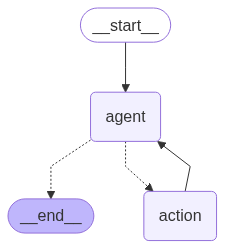

In [43]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

In [49]:
inputs = {"messages": [HumanMessage(content="find mr hotel and flight from mumbai to delhi from starting from 30 aug 2025 to 5 sep 2025 for 2 adults and 1 child with 12 + yeras age with budget of 40000rs including breakfast with free cancellation and flight should be non stop and in morning")]}
for output in app.stream(inputs):
    for value,key in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
        print("\n---\n")



Output from node '{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'mqkjjz6bm', 'function': {'arguments': '{"params":{"adults":2,"arrival_airport":"DEL","children":1,"departure_airport":"BOM","infants_in_seat":0,"infants_on_lap":0,"outbound_date":"2025-08-30","return_date":"2025-09-05"}}', 'name': 'flights_finder'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 183, 'prompt_tokens': 1932, 'total_tokens': 2115, 'completion_time': 0.332727273, 'prompt_time': 0.039829657, 'queue_time': 0.254450889, 'total_time': 0.37255693}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b28e12d5-d74d-4c77-a66f-34502de7621d-0', tool_calls=[{'name': 'flights_finder', 'args': {'params': {'adults': 2, 'arrival_airport': 'DEL', 'children': 1, 'departure_airport': 'BOM', 'infants_in_seat': 0, 'infants_on_lap': 0, 'outbound_date': '2025-08-30'

In [45]:
inputs = {"messages": [HumanMessage(content="Find me a good hotel and flight from New York (JFK) to Los Angeles (LAX) on October 15, 2025 for 2 people.")]}

app.invoke(inputs)

KeyboardInterrupt: 